# Titanic Classification


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action="ignore")

In [2]:
df = sns.load_dataset("titanic")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## 1. EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [4]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categor_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns

In [5]:
numeric_cols = numeric_cols.drop('survived')

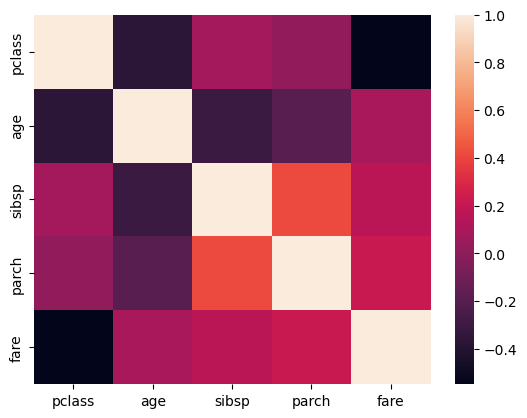

In [6]:
# 상관관계 확인
corr = df[numeric_cols].corr()
sns.heatmap(corr)
plt.show()

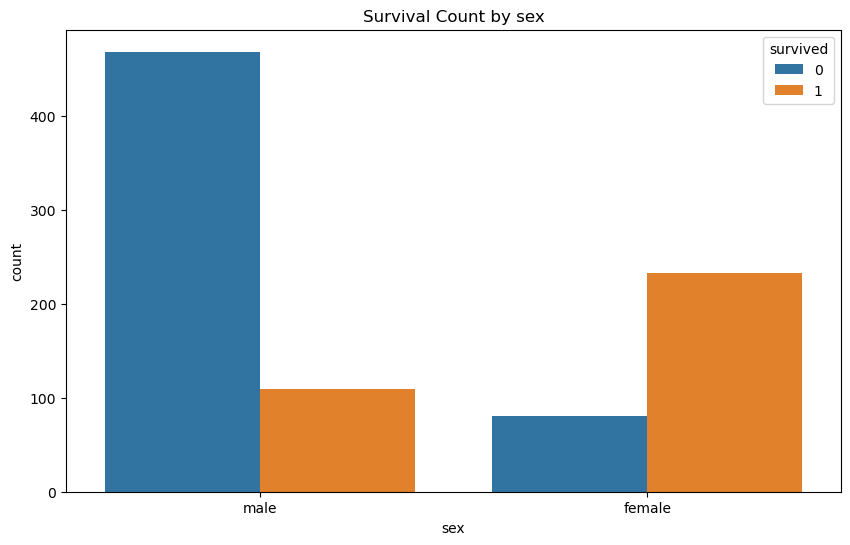

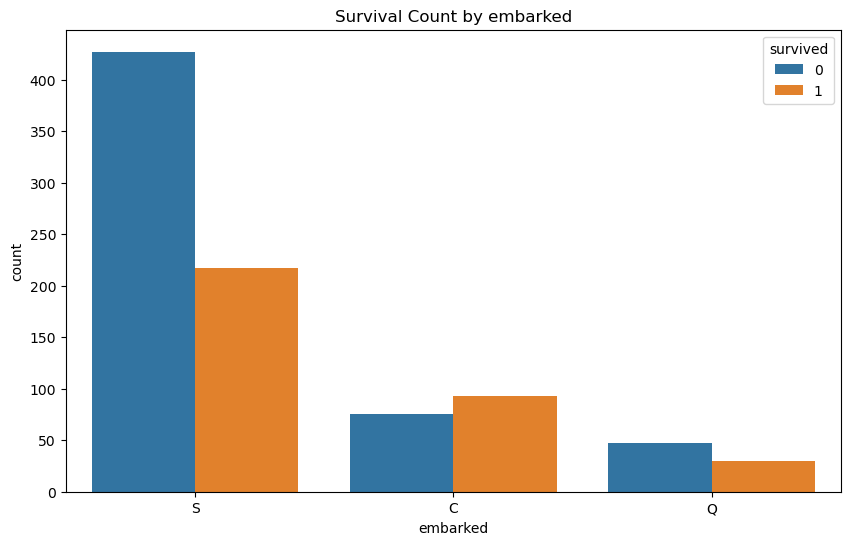

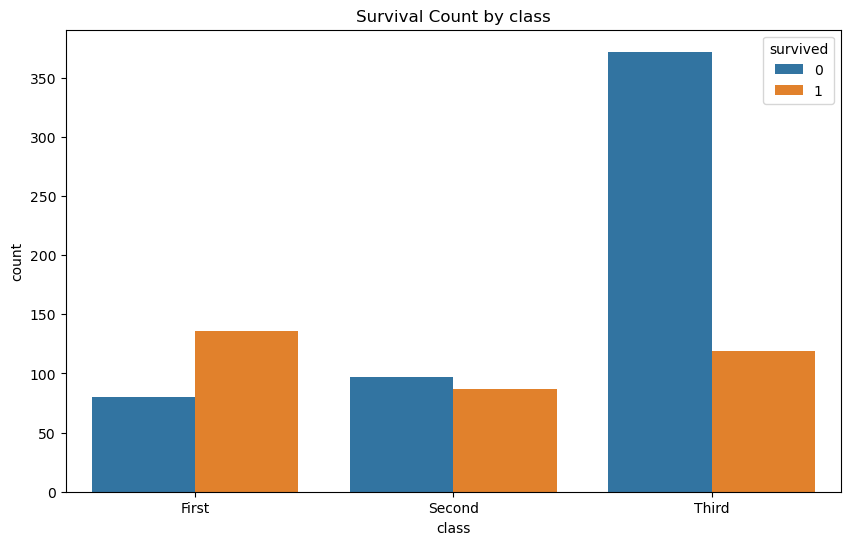

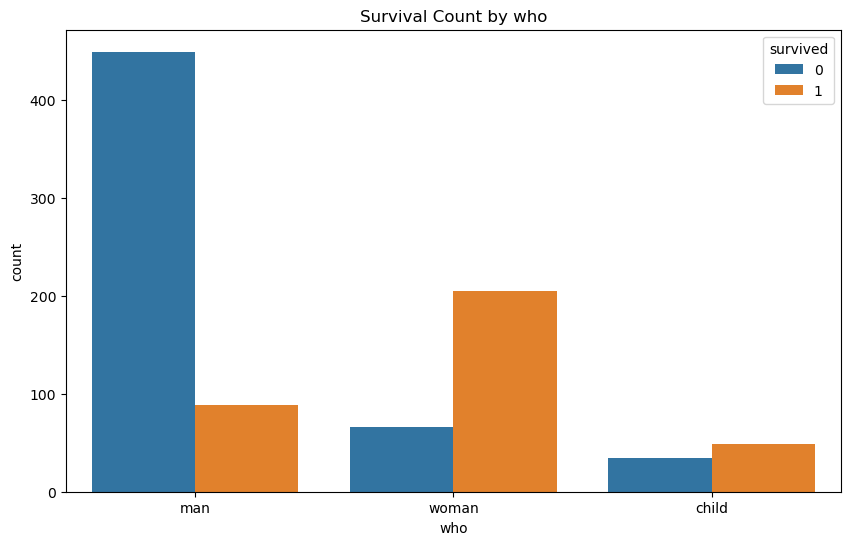

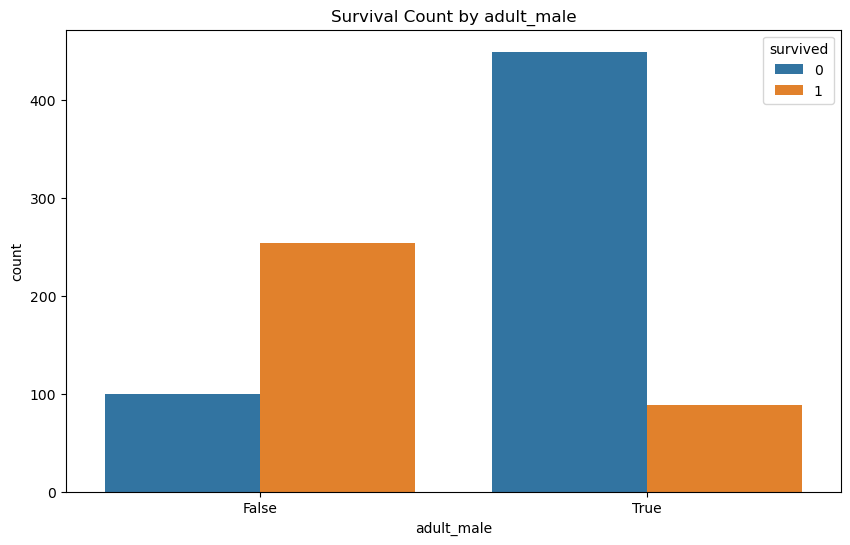

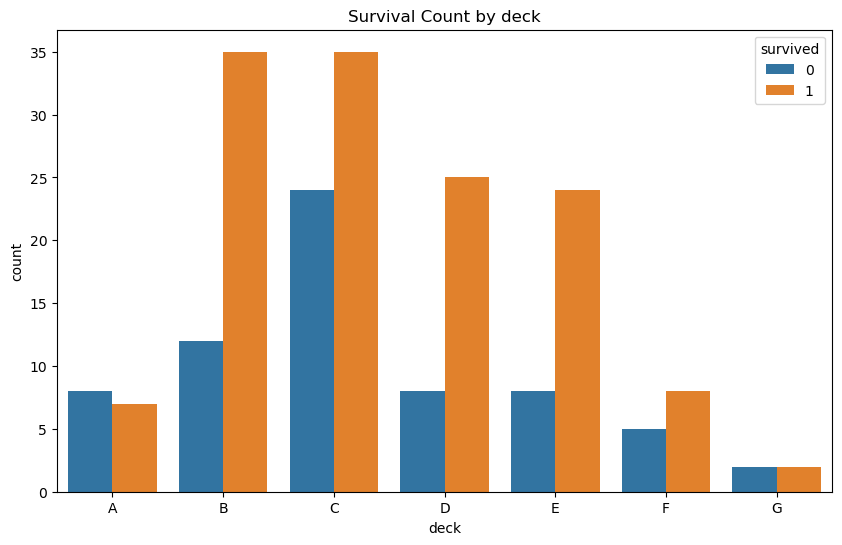

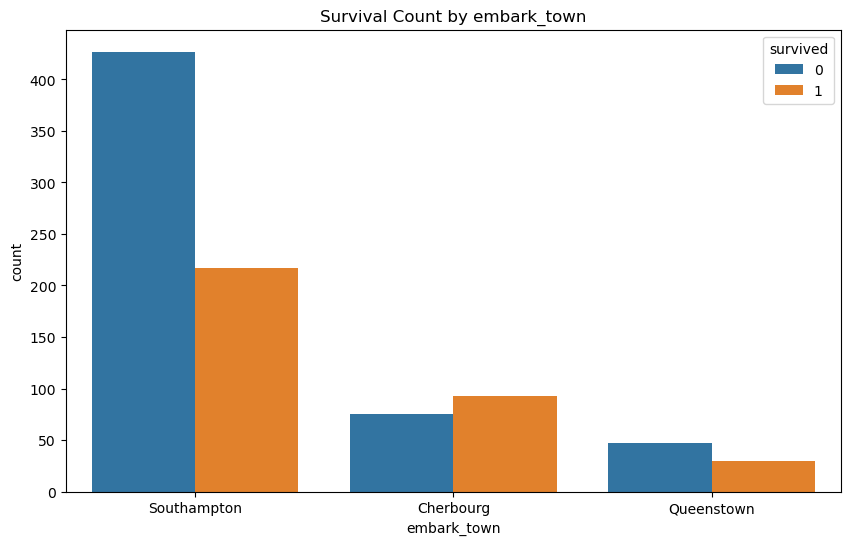

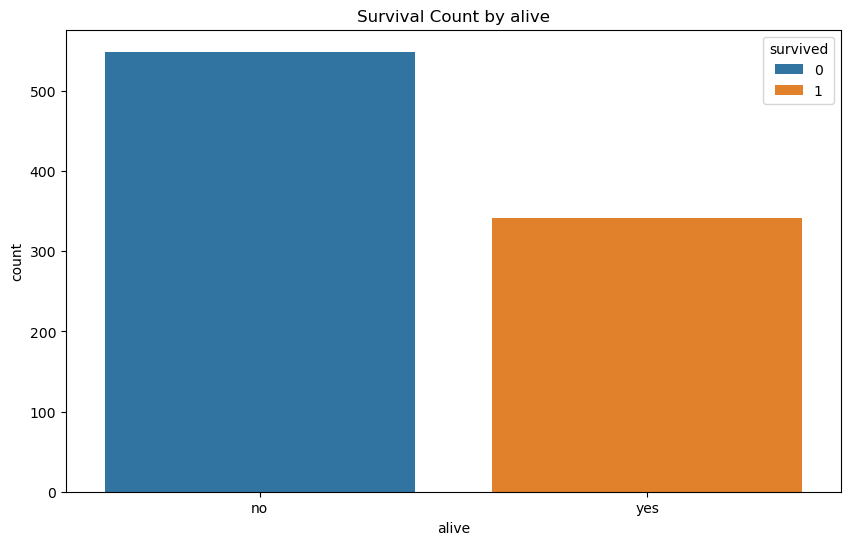

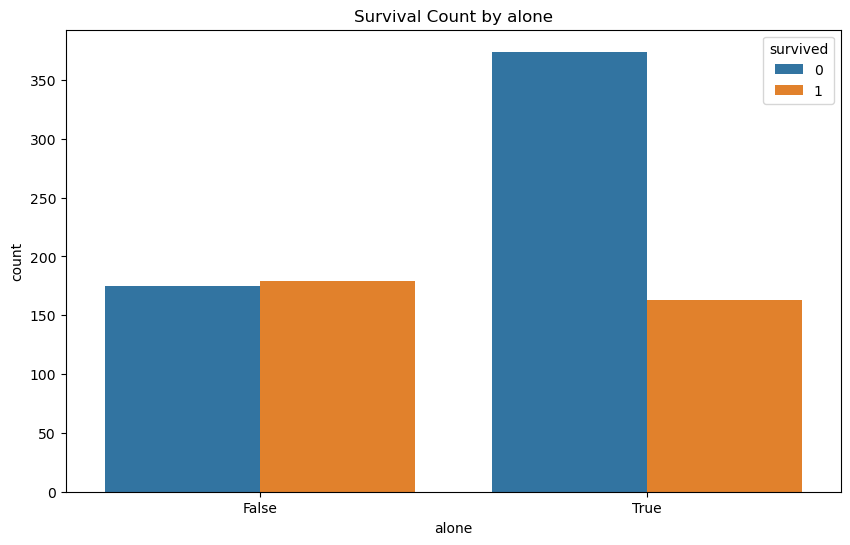

In [7]:
# 범주형 변수와 타겟 변수의 관계 확인
for col in categor_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='survived')
    plt.title(f'Survival Count by {col}')
    plt.show()

## 2. 전처리

In [8]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

### 결측치가 많은 컬럼은 제거

In [9]:
# df = df.drop(columns=['embark_town', 'deck'])

### 결측치를 최빈값으로 대체

In [10]:
df = df.fillna(df.mode().iloc[0])

### IQR 이상치 처리

In [11]:
def outlier_cap(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_cap = Q1 -1.5*IQR
    upper_cap = Q3 + 1.5*IQR
    df[column] = np.where(df[column] < lower_cap, lower_cap, df[column])
    df[column] = np.where(df[column] > upper_cap, upper_cap, df[column])
    
    return df[column]

for num_feature in numeric_cols:
    df[num_feature] = outlier_cap(df, num_feature)

### 범주형 변수 인코딩

In [12]:
categor_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(df[categor_cols])
encoded_cols = encoder.get_feature_names_out(categor_cols)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols)

In [ ]:
df = df.drop(columns=categor_cols).reset_index(drop=True)
df = pd.concat([df, encoded_df], axis= 1)

### 이산형 변수 스케일링

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

## 모델링

### 데이터 분할

In [ ]:
X = df.drop(columns= 'survived')
y = df['survived']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

### GridSearch

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

RF = RandomForestClassifier()
GB = GradientBoostingClassifier()
catboost = CatBoostClassifier()
xgboost = XGBClassifier()
lightgbm = LGBMClassifier()
logistic = LogisticRegression()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'learning_rate': [0.01, 0.1],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [ ]:
rf_grid = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)

gb_grid = GridSearchCV()


### 최적화된 모델 선정

In [ ]:
RF_opt = RandomForestClassifier(**rf_grid.best_params_)


### 앙상블

### Voting Classifier

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

voting_hard = VotingClassifier(estimators=[('rf', RF), ('gb', GB), ('catboost', catboost), ('xgboost', xgboost), ('lightgbm', lightgbm), ('logistic', logistic)], voting='hard')
voting_soft = VotingClassifier(estimators=[('rf', RF), ('gb', GB), ('catboost', catboost), ('xgboost', xgboost), ('lightgbm', lightgbm), ('logistic', logistic)], voting='soft')

voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

y_pred_hard = voting_hard.predict(X_val)
y_pred_soft = voting_soft.predict(X_val)

accuracy_hard = accuracy_score(y_val, y_pred_hard)
accuracy_soft = accuracy_score(y_val, y_pred_soft)

In [ ]:
print(accuracy_hard)
print(accuracy_soft)

### 더 나은 모델을 활용하여 테스트 데이터셋 결과 생성

In [ ]:
test_df = test_df.fillna(mode_values)

